# Datasets comparison between CAMS and IASI (L3)

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [28]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (CO or O3)
component_nom = 'CO'

# Define model
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Define sensor
sensor = 'iasi'
sensor_type = 'L3'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2014-01-01'
end_date = '2021-12-01'

# Define extent
area_name = 'South America'
lon_min = -65
lon_max = -35
lat_min = -34
lat_max = -10

# Define resolution (Minimum: 1x1)
lat_res = 1
lon_res = 1

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_MW, product_type, sensor_column, column_type = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In months: ('2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '202

## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name,
                                               model_level = 'single', CAMS_UID = None, CAMS_key = None)

2022-02-07 19:27:09,910 INFO Welcome to the CDS
2022-02-07 19:27:09,911 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-reanalysis-eac4-monthly
2022-02-07 19:27:09,928 INFO Request is queued


The file does not exist, it will be downloaded.


2022-02-07 19:27:10,939 INFO Request is running
2022-02-07 19:27:42,187 INFO Request is completed
2022-02-07 19:27:42,189 INFO Downloading https://download-0001.copernicus-atmosphere.eu/cache-compute-0001/cache/data3/adaptor.mars.internal-1644262029.9609585-4169-10-54c73b24-9bf7-4f26-8f37-e58c6cf77a8f.grib to /home/alba/adc-toolbox/data/cams/CO/CAMS_REANALYSIS_CO_TC_2014-01-01_2021-12-01_South America.grib (369.1K)
2022-02-07 19:27:42,337 INFO Download rate 2.5M/s


In [8]:
model_ds, dates, model_levels_df = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 33, longitude: 41, time: 90)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2021-06-01
    surface     float64 ...
  * latitude    (latitude) float64 -34.0 -33.25 -32.5 ... -11.5 -10.75 -10.0
  * longitude   (longitude) float64 -65.0 -64.25 -63.5 ... -36.5 -35.75 -35.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-02-07T19:27 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],Depth [m]
hybrid,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2320.96
...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,22.96


### Convert CAMS data units

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_MW, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


### Get CAMS levels (total or tropospheric)

In [11]:
model_ds = CAMS_get_levels_data(model_ds, model_product_name, model_levels_df, 
                                column_type, lat_min, lat_max, lon_min, lon_max)
model_ds

The model total columns will be compared to the total sensor columns.


<xarray.Dataset>
Dimensions:     (latitude: 33, longitude: 41, time: 90)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2021-06-01
    surface     float64 0.0
  * latitude    (latitude) float64 -34.0 -33.25 -32.5 ... -11.5 -10.75 -10.0
  * longitude   (longitude) float64 -65.0 -64.25 -63.5 ... -36.5 -35.75 -35.0
    valid_time  (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2021-06-01
Data variables:
    component   (time, latitude, longitude) float32 1.339e+18 ... 1.305e+18
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-02-07T19:27 GRIB to CDM+CF via cfgrib-0.9.9...

## 3. Sensor data

In [12]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

RESULTS
For 2014-01:
IASI_METOPA_L3_CO_COLUMN_201401_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_201401_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPC_L3_CO_COLUMN_201401_ULB-LATMOS_V20151001.0.nc is not available.
For 2014-02:
IASI_METOPA_L3_CO_COLUMN_201402_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_201402_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPC_L3_CO_COLUMN_201402_ULB-LATMOS_V20151001.0.nc is not available.
For 2014-03:
IASI_METOPA_L3_CO_COLUMN_201403_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_201403_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPC_L3_CO_COLUMN_201403_ULB-LATMOS_V20151001.0.nc is not available.
For 2014-04:
IASI_METOPA_L3_CO_COLUMN_201404_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_201404_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPC_L3_CO_COLUMN_201404_ULB-LATMOS_V20151001.0.nc is not available.
For 2014-05:
IASI_METOPA_L3_CO_COLUMN_201405

In [13]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, dates, lat_res, lon_res)
sensor_ds

<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 89)
Coordinates:
  * longitude       (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude        (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time            (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2021-06-01
Data variables:
    sensor_column   (time, longitude, latitude) float32 0.01073 0.01035 ... nan
    COgridNIGHT     (time, longitude, latitude) float32 nan nan nan ... nan nan
    ErrorgridDAY    (time, longitude, latitude) float32 0.0004424 ... nan
    ErrorgridNIGHT  (time, longitude, latitude) float32 nan nan nan ... nan nan
Attributes:
    units:    mol m-2

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [14]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component_nom)
sensor_ds

The sensor component units have been converted from mol m-2 to molec cm-2.


<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 89)
Coordinates:
  * longitude       (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude        (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time            (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2021-06-01
Data variables:
    sensor_column   (time, longitude, latitude) float64 6.461e+17 ... nan
    COgridNIGHT     (time, longitude, latitude) float64 nan nan nan ... nan nan
    ErrorgridDAY    (time, longitude, latitude) float64 2.664e+16 ... nan
    ErrorgridNIGHT  (time, longitude, latitude) float64 nan nan nan ... nan nan
Attributes:
    units:    molec cm-2

## 4. Match data

In [15]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR MONTH: 2014-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2014-02
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2014-03
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2014-04
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2014-05
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2014-06
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2014-07
The model dataset does not contain levels data.
The model dataset will be merged with the sensor da

,latitude,longitude,time,sensor_column,COgridNIGHT,ErrorgridDAY,ErrorgridNIGHT,model_column
0,-34.5,-65.5,2014-01-01,1.031864e+18,1.001211e+18,3.065369e+15,1.197104e+16,1.338993e+18
1,-34.5,-64.5,2014-01-01,1.081744e+18,1.021537e+18,3.493928e+15,1.415645e+16,1.350042e+18
2,-34.5,-63.5,2014-01-01,1.119616e+18,1.045372e+18,4.262415e+15,1.543002e+16,1.356983e+18
3,-34.5,-62.5,2014-01-01,1.117397e+18,1.034786e+18,4.914175e+15,1.652040e+16,1.358055e+18
4,-34.5,-61.5,2014-01-01,1.087278e+18,1.034450e+18,5.308688e+15,1.546557e+16,1.368285e+18
...,...,...,...,...,...,...,...,...
770,-10.5,-39.5,2021-06-01,1.661891e+18,1.718461e+18,1.197185e+16,1.089853e+16,1.299868e+18
771,-10.5,-38.5,2021-06-01,1.692622e+18,1.755065e+18,1.146977e+16,1.231675e+16,1.292434e+18
772,-10.5,-37.5,2021-06-01,1.703438e+18,1.759073e+18,1.036992e+16,1.272598e+16,1.305267e+18
773,-10.5,-36.5,2021-06-01,1.663701e+18,1.705949e+18,9.367539e+15,1.008229e+16,1.306431e+18


## 5. Merge data and calculate difference

In [16]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column    difference  \
latitude longitude time                                                    
-34.5    -65.5     2014-01-01  1.338993e+18   1.031864e+18  3.071291e+17   
         -64.5     2014-01-01  1.350042e+18   1.081744e+18  2.682976e+17   
         -63.5     2014-01-01  1.356983e+18   1.119616e+18  2.373674e+17   
         -62.5     2014-01-01  1.358055e+18   1.117397e+18  2.406574e+17   
         -61.5     2014-01-01  1.368285e+18   1.087278e+18  2.810076e+17   
...                                     ...            ...           ...   
-10.5    -39.5     2021-06-01  1.299868e+18   1.661891e+18 -3.620228e+17   
         -38.5     2021-06-01  1.292434e+18   1.692622e+18 -4.001878e+17   
         -37.5     2021-06-01  1.305267e+18   1.703438e+18 -3.981710e+17   
         -36.5     2021-06-01  1.306431e+18   1.663701e+18 -3.572700e+17   
         -35.5     2021-06-01  1.304022e+18   1.639813e+18 -3.357912e+17   

                               relative_difference  
latitude longitude time                             
-34.5    -65.5     2014-01-01             0.297645  
         -64.5     2014-01-01             0.248023  
         -63.5     2014-01-01             0.212008  
         -62.5     2014-01-01             0.215373  
         -61.5     2014-01-01             0.258451  
...                                            ...  
-10.5    -39.5     2021-06-01            -0.217838  
         -38.5     2021-06-01            -0.236431  
         -37.5     2021-06-01            -0.233745  
         -36.5     2021-06-01            -0.214744  
         -35.5     2021-06-01            -0.204774  

[68975 rows x 4 columns]

In [17]:
descr_stats_table = merge_df.describe()
descr_stats_table

,model_column,sensor_column,difference,relative_difference
count,6.897500e+04,6.897400e+04,6.897400e+04,68974.000000
mean,1.644042e+18,1.614834e+18,2.920587e+16,0.030263
std,4.354105e+17,4.762947e+17,2.084324e+17,0.124673
min,8.433952e+17,7.340443e+17,-1.993128e+18,-0.354851
25%,1.335421e+18,1.311144e+18,-9.487757e+16,-0.058785
50%,1.520051e+18,1.507277e+18,2.219681e+16,0.014862
75%,1.833997e+18,1.774463e+18,1.445990e+17,0.102184
max,4.692693e+18,5.932966e+18,1.379695e+18,0.841184


## 6. Show comparison plots

### Select plot dates

In [18]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2014-01' '2014-02' '2014-03' '2014-04' '2014-05' '2014-06' '2014-07'
 '2014-08' '2014-09' '2014-10' '2014-11' '2014-12' '2015-01' '2015-02'
 '2015-03' '2015-04' '2015-05' '2015-06' '2015-07' '2015-08' '2015-09'
 '2015-10' '2015-11' '2015-12' '2016-01' '2016-02' '2016-03' '2016-04'
 '2016-05' '2016-06' '2016-07' '2016-08' '2016-09' '2016-10' '2016-11'
 '2016-12' '2017-01' '2017-02' '2017-03' '2017-04' '2017-05' '2017-06'
 '2017-07' '2017-08' '2017-09' '2017-10' '2017-11' '2017-12' '2018-01'
 '2018-02' '2018-03' '2018-04' '2018-05' '2018-06' '2018-07' '2018-08'
 '2018-09' '2018-10' '2018-11' '2018-12' '2019-01' '2019-02' '2019-03'
 '2019-04' '2019-05' '2019-06' '2019-07' '2019-08' '2019-09' '2019-10'
 '2019-11' '2020-01' '2020-02' '2020-03' '2020-04' '2020-05' '2020-06'
 '2020-07' '2020-08' '2020-09' '2020-10' '2020-11' '2020-12' '2021-01'
 '2021-02' '2021-03' '2021-04' '2021-05' '2021-06']


### Select plot extent

In [19]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-65, -34), (-35, -10))


### Compare CAMS and IASI total columns

Frame length between -65 and -35 should be one of these options: [1, 2, 3, 5, 6, 10, 15, 30]
Frame length between -34 and -10 should be one of these options: [1, 2, 3, 4, 6, 8, 12, 24]


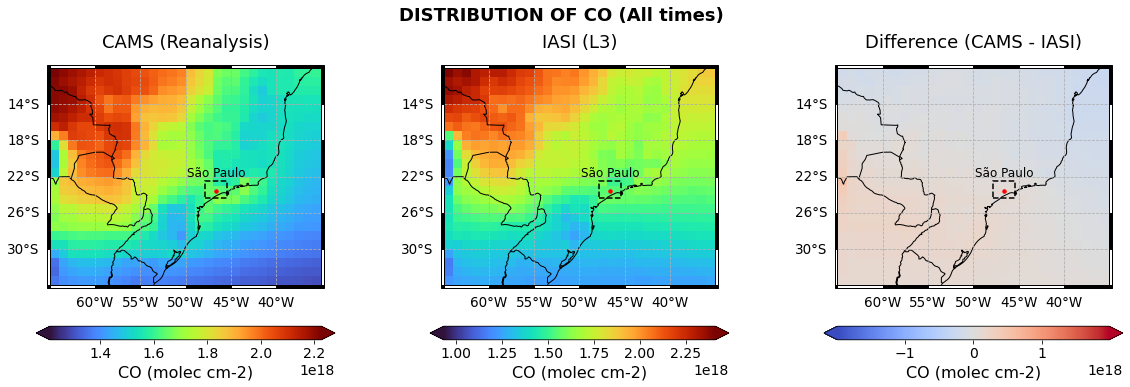

In [20]:
# Choose distribution (aggregated, individual, seasonal or animated)
plot_type = 'aggregated'

# Define range (original, equal, centered or manual)
range_type = 'original'
vmin_manual, vmax_manual = None, None
vmin_manual_diff, vmax_manual_diff = None, None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['turbo', 'turbo', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 5
height_lat = 4

# Add markers
regions_names = ('São Paulo')
bbox_list = (-24.4, -22.5, -47.86, -45.43)
coords_list = (-23.56, -46.64)

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, plot_type, projection,
                          color_scale, width_lon, height_lat, vmin_manual, vmax_manual, 
                          vmin_manual_diff, vmax_manual_diff, bbox_list, coords_list, regions_names)

## 7. Retrieve nearest values to specific coordinates

model_column  \
region    lat_search lon_search latitude longitude time                       
São Paulo -23.56     -46.64     -23.5    -46.5     2014-01-01  1.480060e+18   
                                                   2014-02-01  1.389893e+18   
                                                   2014-03-01  1.379417e+18   
                                                   2014-04-01  1.380409e+18   
                                                   2014-05-01  1.359352e+18   
...                                                                     ...   
                                                   2021-02-01  1.470371e+18   
                                                   2021-03-01  1.508053e+18   
                                                   2021-04-01  1.192634e+18   
                                                   2021-05-01  1.319209e+18   
                                                   2021-06-01  1.403097e+18   

                                                               sensor_column  \
region    lat_search lon_search latitude longitude time                        
São Paulo -23.56     -46.64     -23.5    -46.5     2014-01-01   1.465655e+18   
                                                   2014-02-01   1.467712e+18   
                                                   2014-03-01   1.295245e+18   
                                                   2014-04-01   1.313973e+18   
                                                   2014-05-01   1.204423e+18   
...                                                                      ...   
                                                   2021-02-01   1.431627e+18   
                                                   2021-03-01   1.561884e+18   
                                                   2021-04-01   1.271460e+18   
                                                   2021-05-01   1.345275e+18   
                                                   2021-06-01   1.334792e+18   

                                                                 difference  \
region    lat_search lon_search latitude longitude time                       
São Paulo -23.56     -46.64     -23.5    -46.5     2014-01-01  1.440549e+16   
                                                   2014-02-01 -7.781870e+16   
                                                   2014-03-01  8.417192e+16   
                                                   2014-04-01  6.643605e+16   
                                                   2014-05-01  1.549288e+17   
...                                                                     ...   
                                                   2021-02-01  3.874375e+16   
                                                   2021-03-01 -5.383052e+16   
                                                   2021-04-01 -7.882555e+16   
                                                   2021-05-01 -2.606557e+16   
                                                   2021-06-01  6.830487e+16   

                                                               relative_difference  
region    lat_search lon_search latitude longitude time                             
São Paulo -23.56     -46.64     -23.5    -46.5     2014-01-01             0.009829  
                                                   2014-02-01            -0.053020  
                                                   2014-03-01             0.064985  
                                                   2014-04-01             0.050561  
                                                   2014-05-01             0.128633  
...                                                                            ...  
                                                   2021-02-01             0.027063  
                                                   2021-03-01            -0.034465  
                                                   2021-04-01            -0.061996  
                               

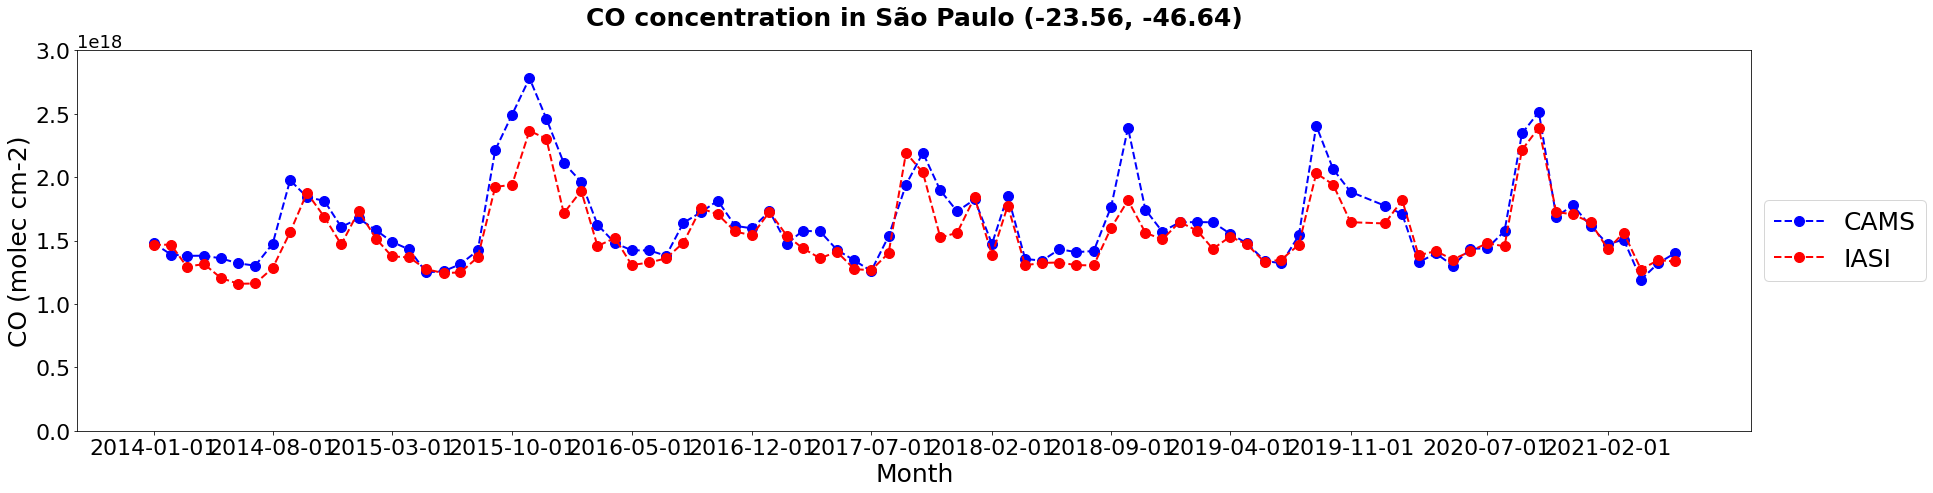

In [21]:
regions_names = ('São Paulo')
coords_list = (-23.56, -46.64)
ymin = 0
ymax = 3*10**18
xticks = plot_dates[0::7]

timeseries_table = timeseries(merge_df, component_nom, sensor, sensor_type, model, 
                              plot_dates, units, ymin, ymax, xticks, regions_names, coords_list)
timeseries_table

## 8. Monthly annual cycle

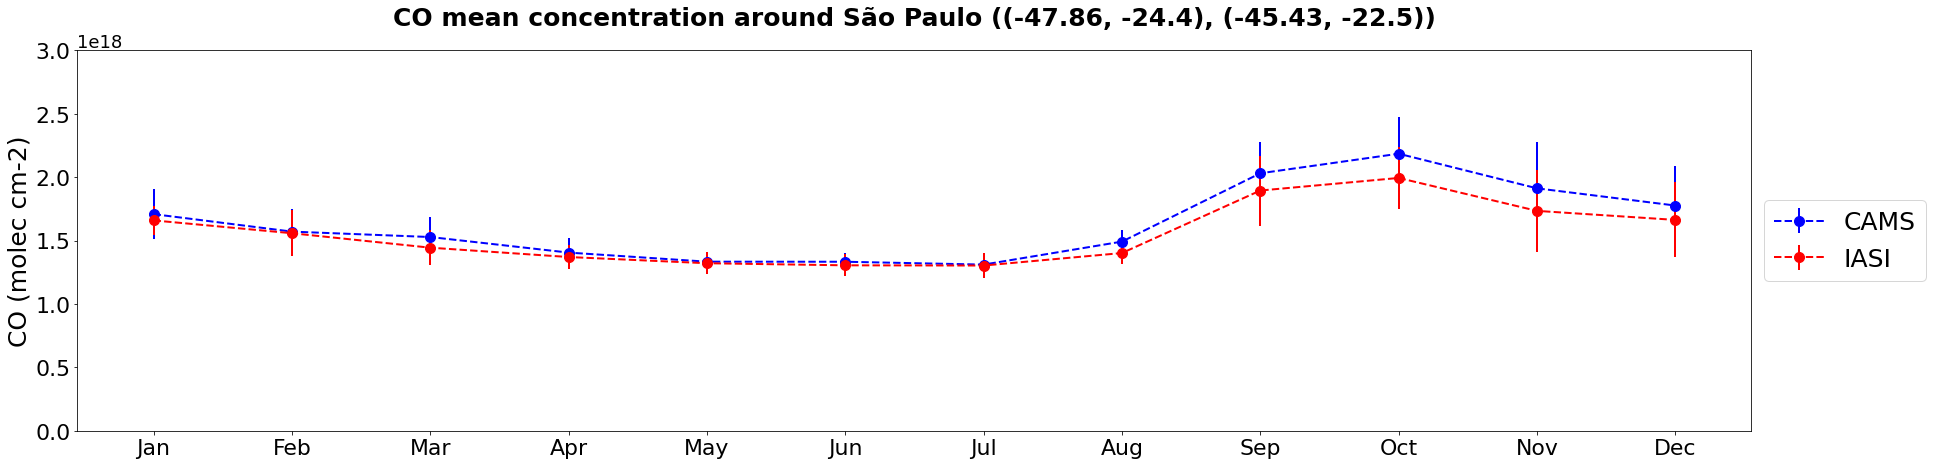

,location,month,model mean,model std,sensor mean,sensor std
0,São Paulo,1,1.708298e+18,1.946546e+17,1.658869e+18,1.119365e+17
1,São Paulo,2,1.570394e+18,1.755351e+17,1.557653e+18,1.793883e+17
2,São Paulo,3,1.527730e+18,1.596335e+17,1.443686e+18,1.400245e+17
3,São Paulo,4,1.405031e+18,1.156374e+17,1.370076e+18,9.600126e+16
4,São Paulo,5,1.333371e+18,7.503493e+16,1.321099e+18,8.760303e+16
5,São Paulo,6,1.332760e+18,6.963072e+16,1.304635e+18,8.776383e+16
6,São Paulo,7,1.310349e+18,7.072274e+16,1.302934e+18,1.007765e+17
7,São Paulo,8,1.491611e+18,9.103471e+16,1.401507e+18,8.891552e+16
8,São Paulo,9,2.030378e+18,2.460914e+17,1.894323e+18,2.760678e+17
9,São Paulo,10,2.184548e+18,2.890338e+17,1.993436e+18,2.439962e+17


In [22]:
regions_names = ('São Paulo')
bbox_list = (-24.4, -22.5, -47.86, -45.43)
ymin = 0*10**18
ymax = 3*10**18

monthly_annual_cycle_table = monthly_annual_cycle(merge_df, component_nom, sensor, model, units, 
                                                  ymin, ymax, regions_names, bbox_list)
monthly_annual_cycle_table

## 9. Trends

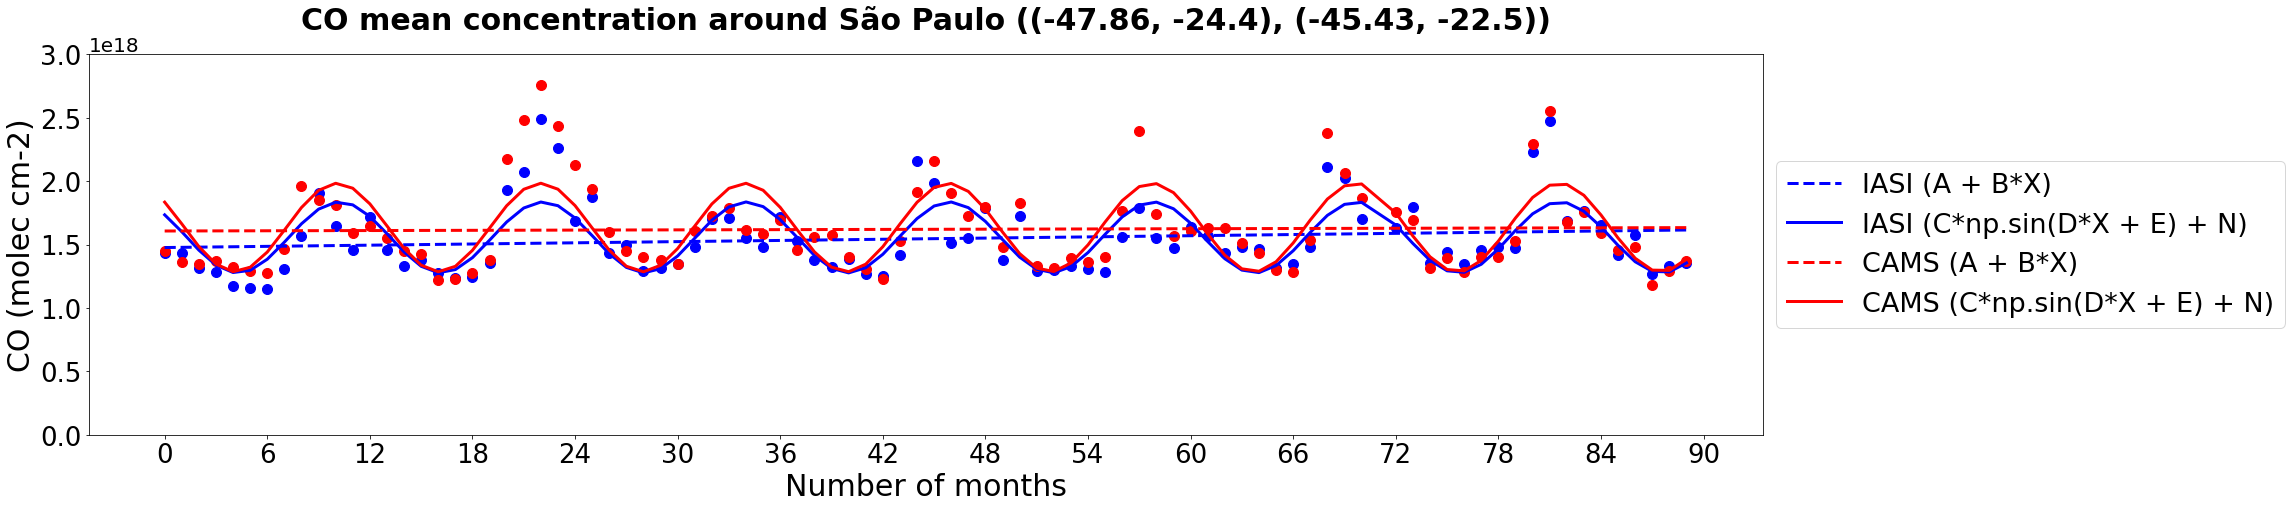

,Location,Source,Rate (molec cm-2 y-1),Rate (% y-1),A,B,C,D,E,N,Linear R2,Linear RMSE,Linear MSE,Sinusoidal R2,Sinusoidal RMSE,Sinusoidal MSE
0,São Paulo,Sensor,1.863986e+16,1.262554,1.476362e+18,1.553322e+15,-2.797115e+17,0.528228,-0.690217,1.556105e+18,0.020052,2.820191e+17,7.953479e+34,0.479059,2.056228e+17,4.228073e+34
1,São Paulo,Model,3.587312e+15,0.223267,1.606739e+18,2.989426e+14,-3.491772e+17,0.527442,-0.610192,1.634259e+18,0.000532,3.366191e+17,1.133124e+35,0.534318,2.297730e+17,5.279564e+34


In [29]:
regions_names = ('São Paulo')
bbox_list = (-24.4, -22.5, -47.86, -45.43)
ymin = 0
ymax = 3*10**18
sensor_break_date = None # None or date as a string
model_break_date = None # None or date as a string

trends_table = trends(merge_df, component_nom, sensor, model, units, ymin, ymax, 
                      plot_dates, regions_names, bbox_list, sensor_break_date, model_break_date)
trends_table

Frame length between -65 and -35 should be one of these options: [1, 2, 3, 5, 6, 10, 15, 30]
Frame length between -34 and -10 should be one of these options: [1, 2, 3, 4, 6, 8, 12, 24]


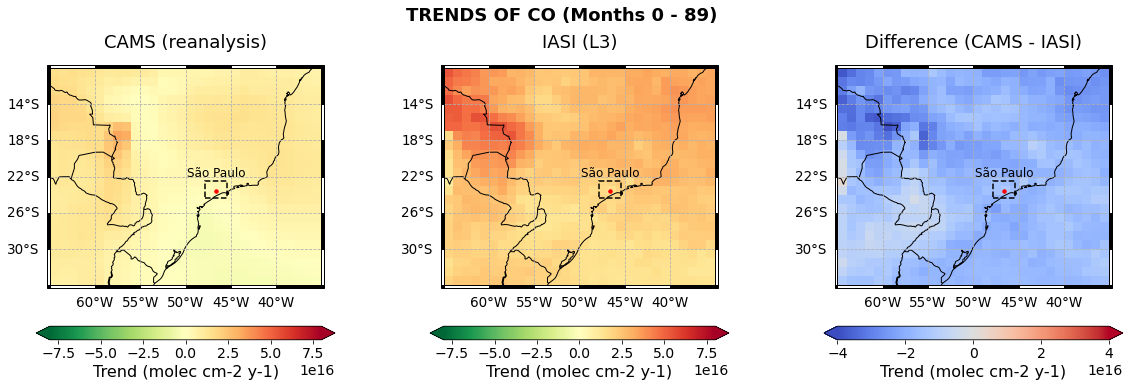

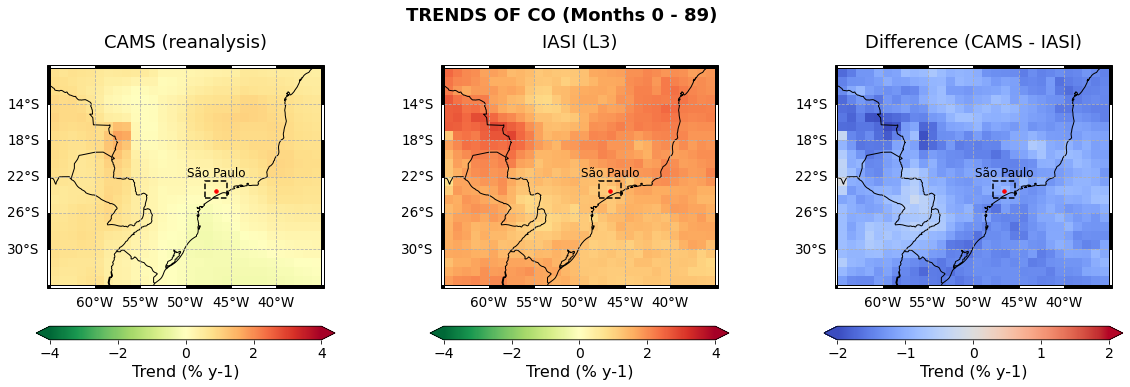

In [35]:
# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['RdYlGn_r', 'RdYlGn_r', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 5
height_lat = 4

# Define break dates (None or both the same)
sensor_break_date = None # None or date as a string
model_break_date = None # None or date as a string

# Define range
vmax_manual_rate_units, vmin_manual_rate_units = 0.8*10**17, -0.8*10**17
vmax_manual_rate_diff_units, vmin_manual_rate_diff_units = 0.4*10**17, -0.4*10**17
vmax_manual_rate_100, vmin_manual_rate_100 = 4, -4
vmax_manual_rate_diff_100, vmin_manual_rate_diff_100 = 2, -2

bbox_trends_table = visualize_bbox_trends(merge_df, component_nom, sensor, model, units, plot_dates, 
                                          sensor_break_date, model_break_date, 20, 1.05,
                                          vmin_manual_rate_units, vmax_manual_rate_units, 
                                          vmin_manual_rate_100, vmax_manual_rate_100,
                                          vmin_manual_rate_diff_units, vmax_manual_rate_diff_units, 
                                          vmin_manual_rate_diff_100, vmax_manual_rate_diff_100,
                                          width_lon, height_lat, 
                                          bbox_list, coords_list, regions_names)

## 10. Scatter plots by bbox

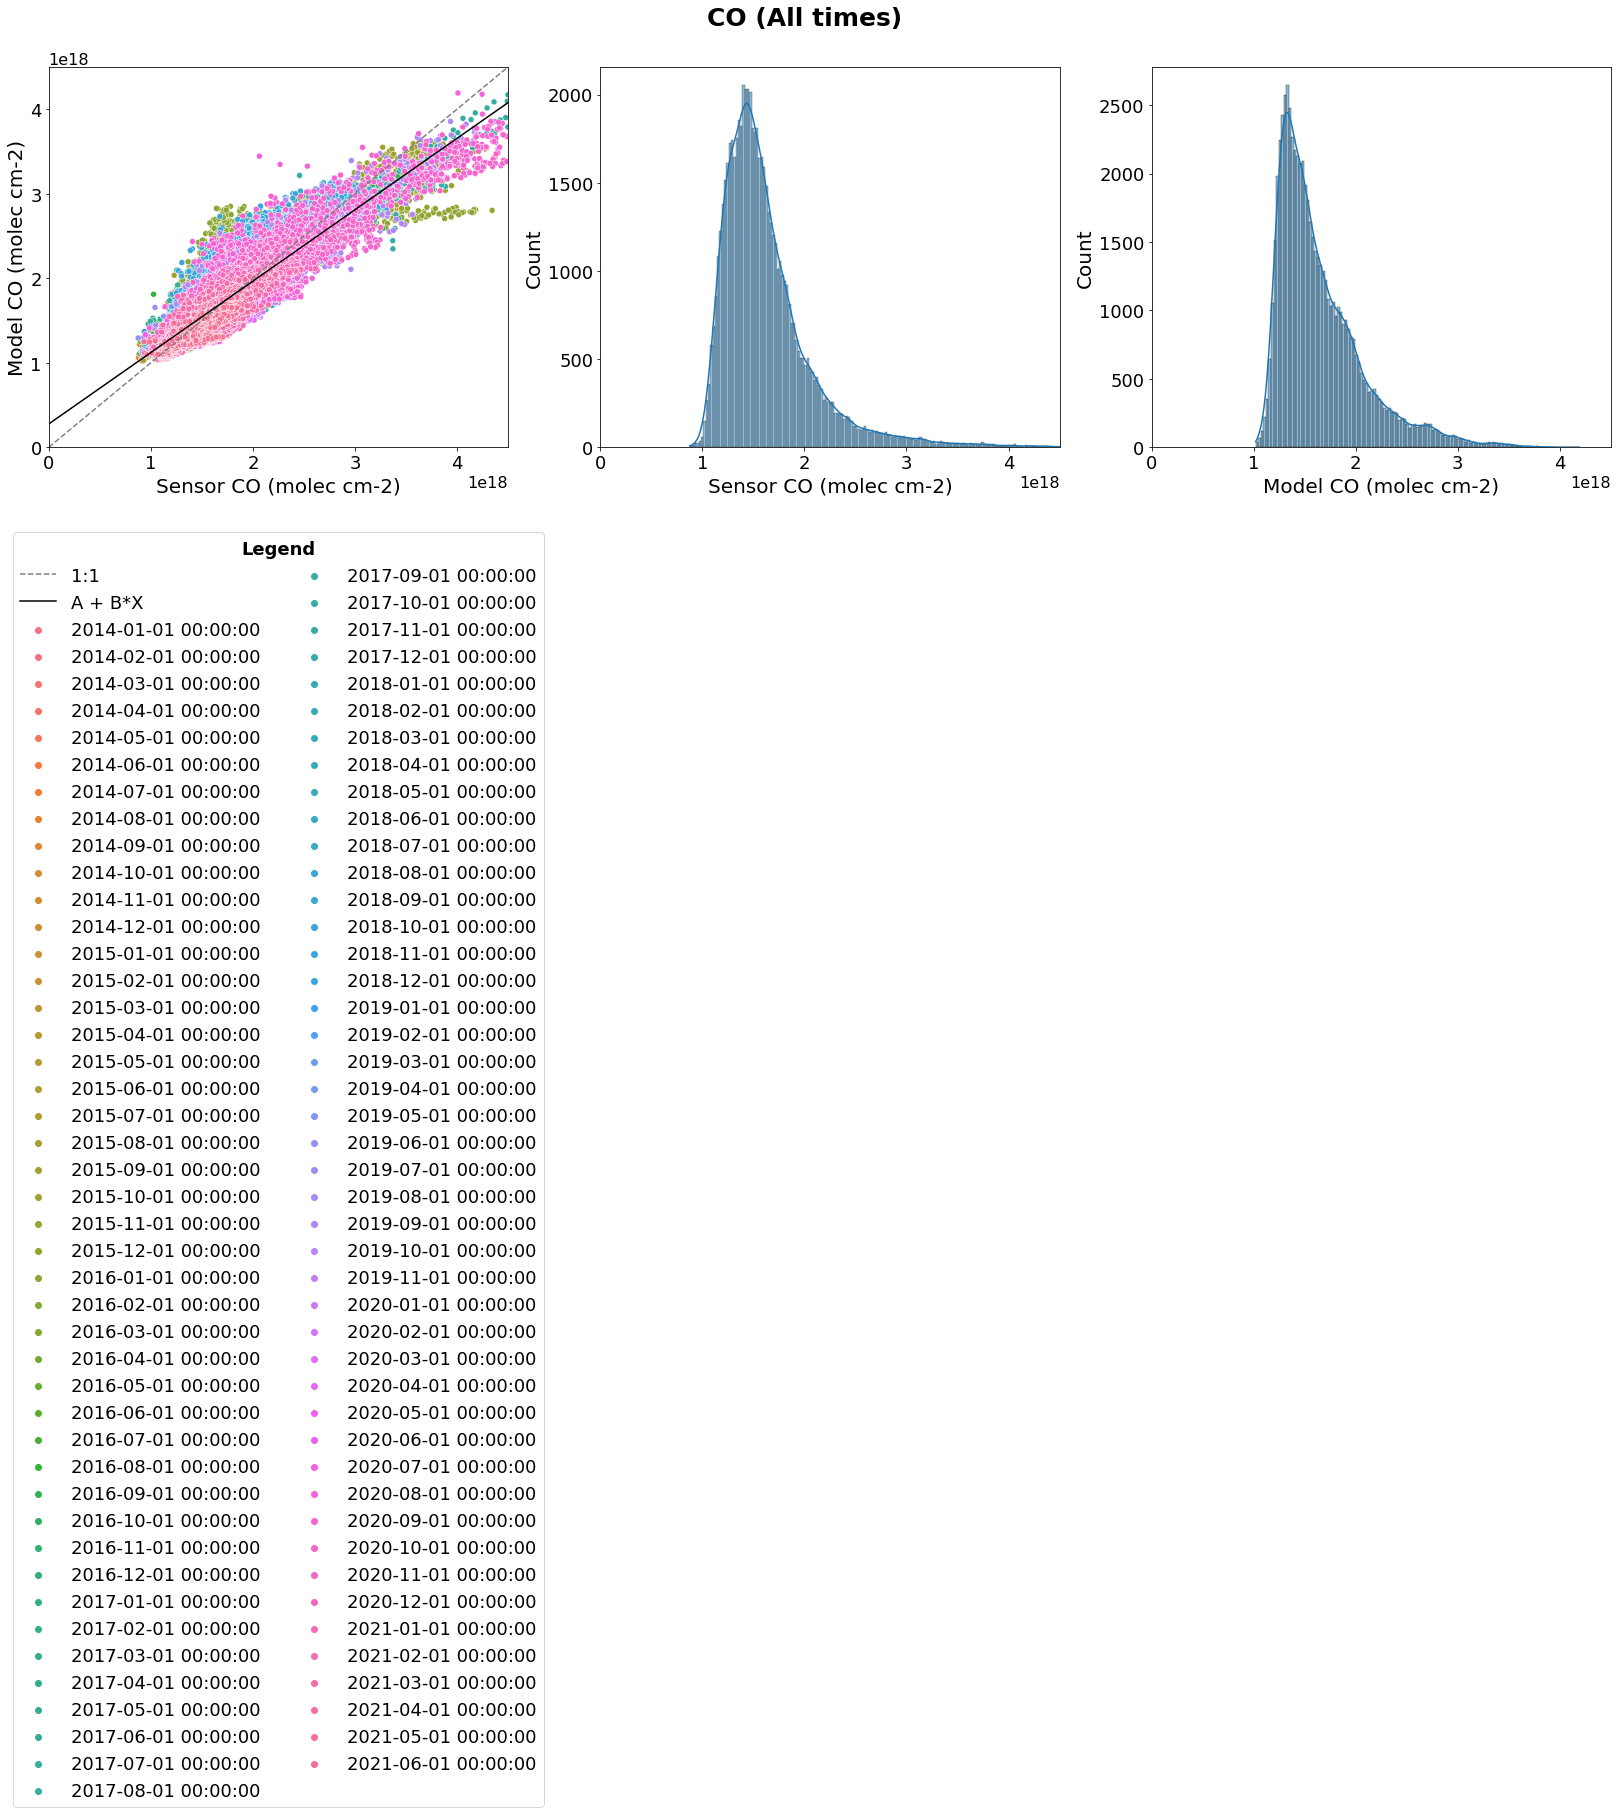

,Period,Location,A,B,R2,RMSE,MSE
0,"[2014-01-01T00:00:00.000000000, 2014-02-01T00:...","((-65, -34), (-35, -10))",0.844833,2.755422e+17,0.800385,1.892193e+17,3.580394e+34


In [31]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 0
lim_max = 4.5*10**18

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, 
                       lim_min, lim_max, plot_bbox)
summary

## 11. Scatter plots by season

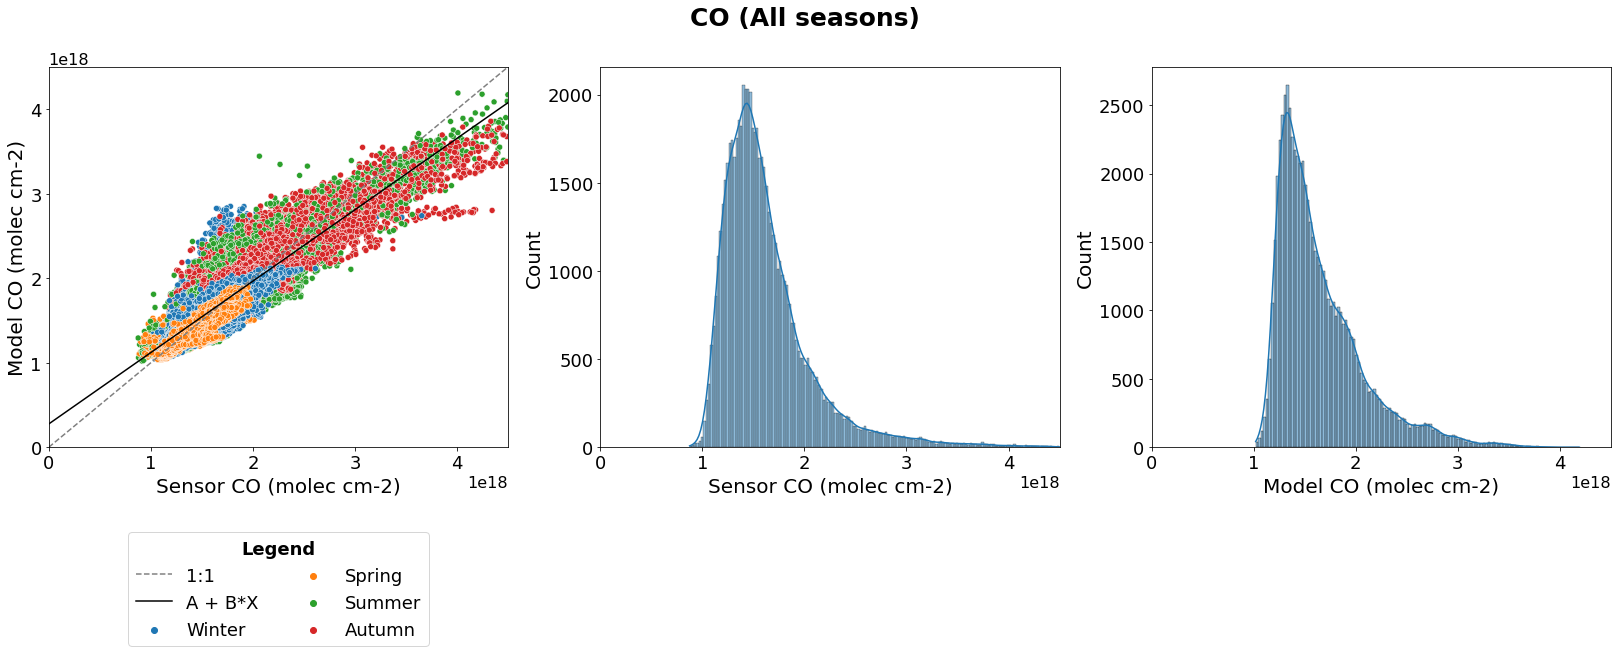

,Period,Location,A,B,R2,RMSE,MSE
0,"[Autumn, Spring, Summer, Winter]","((-65, -34), (-35, -10))",0.844833,2.755422e+17,0.800385,1.892193e+17,3.580394e+34


In [32]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 0
lim_max = 4.5*10**18

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, 
                       lim_min, lim_max, plot_bbox)
summary

## 12. Scatter plots by country (Google API required!)

In [33]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Colombia']

lim_min = 0
lim_max = 4.5*10**18

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, 
                       lim_min, lim_max, plot_countries)
summary
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Colombia']\n\nlim_min = 0\nlim_max = 4.5*10**18\n\nsummary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, \n                       extent_definition, show_seasons, scatter_plot_type, \n                       lim_min, lim_max, plot_countries)\nsummary\n"